# 간단한 단어분류 프로젝트를 통한 자연어처리 이해

#1. 프로젝트의 목적

이번 프로젝트는 문장의 각 단어를 명사(1)와 기타(0)로 분류하는 단어 단위 분류모델입니다.

이와 같이 각 단어별로 예측하는 Task는 다음과 같은 종류들이 있습니다.

- NER(Named Entity Recognition) : 문장 내의 각 단어를 '사람','장소','시간' 등의 정보로 분류하는 Task입니다.
- POS(Part Of Speech) Tagging : 문장 내의 각 단어를 '명사', '동사','부사'등 품사로 분류하는 Task입니다.
- Language Model: 생성할 문장의 각 단어에 대한 다음 단어를 예측하는 방식으로 동작합니다.

#2. 프로젝트 Workflow

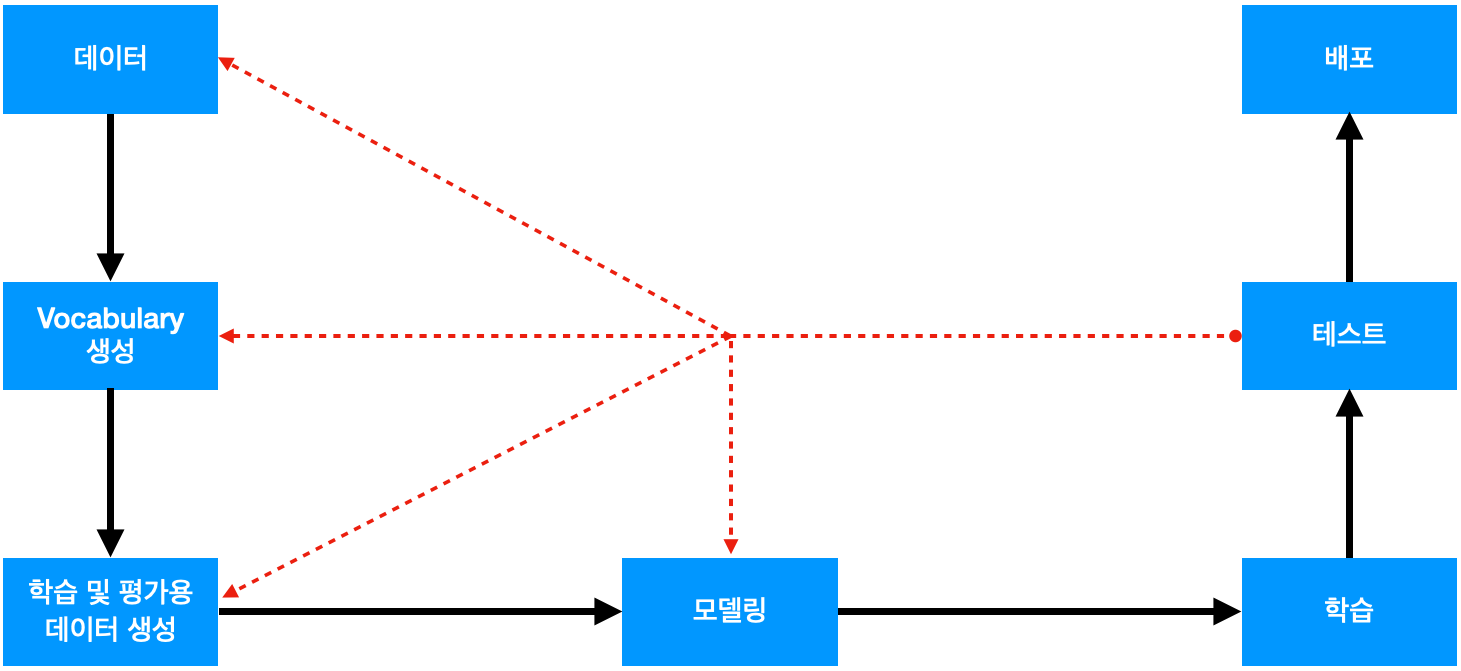

- 데이터
 - 목적에 필요한 정답이 포함된 데이터를 수집하거나 직접 생성 합니다.
 - 이 프로젝트의 경우는 각 단어가 명사인지 여부를 표시해놓은 데이터가 필요합니다.
- Vocabulary 생성
 - 수집된 데이터를 일정한 단위로 일련번호를 부여하는 과정입니다.
 - 자연어처리에서는 컴퓨터에 입력할 때 글자가 아닌 vocabulary에 부여된 일련번호를 입력합니다.
- 학습 및 평가용 데이터 생성
 - 데이터를 vocabulary를 이용해서 일련번호로 변경 후 학습에 적합한 형태로 가공하는 과정입니다.
- 모델링
 - 목적에 적합한 모델을 생성합니다.
- 학습
 - 데이터를 이용해서 모델을 학습하는 과정입니다.
- 테스트
 - 학습된 모델을 테스트하는 과정입니다.
 - 모델을 테스트해서 성능이 기준치보다 좋으면 서비스에 배포 합니다.
 - 만일 모델의 성능이 기준치보다 성능이 낮은 경우는 원인을 분석하고 문제가 된다고 생각되는 과정으로 돌아가서 그 과정을 개선하고 다시 학습하고 테스트해 봅니다.
- 배포
 - 학습된 모델을 이용하여 실제 문제에 적용해서 문제를 개선하는 과정입니다.

#3. 프로젝트 환경

In [1]:
# 필요한 library import

import argparse
import random

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
# 학습 환경 설정

args = {
    # random seed value
    "seed": 9999,
    # number of epoch
    "n_epoch": 200,
    # number of batch
    "n_batch": 2,
    # learning rate
    "lr": 0.001,
    # weights 저장 위치
    "save_path": "01-01-sequence-prediction.pth",
    # CPU 또는 GPU 사용여부 결정
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=9999, n_epoch=200, n_batch=2, lr=0.001, save_path='01-01-sequence-prediction.pth', device=device(type='cpu'))


Random seed를 설정하는 이유는 pytorch가 random하게 초깃값을 설정하는데 이 값이 다를 경우 학습 결과가 달라질 수 있어서 항상 같은 값을 가지도록 하기 위해서입니다.

In [3]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

#4. 데이터

목적에 맞는 데이터를 수집하고 정답 라벨은 만드는 과정은 어렵고 전체 과정 중 가장 중요한 과정이라고 할 수 있습니다.

수집된 데이터를 학습용(60%),검증용(20%),테스트용(20%) 형태로 분할하는 것이 일반적이나, 만일 데이터 수가 적다면 학습용(80%), 검증용 및 테스트용(20%) 형태로 분할합니다.
중요한 것은 학습용 이외에 적당한 양의 평가 데이터가 필요하다는 것입니다.

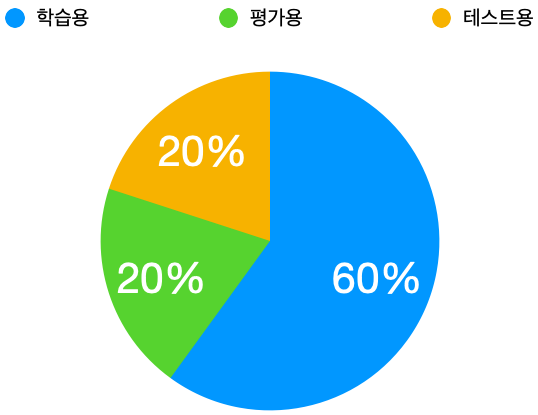

In [29]:
# 입력 문장 : 학습용 데이터
raw_inputs = [
    "나는 학생 입니다",
    "나는 좋은 선생님 입니다",
    "당신은 매우 좋은 선생님 입니다"
]

In [30]:
# 정답 데이터 : 명사(1), 기타(0)

raw_labels = [
    [0,1,0],
    [0,0,1,0],
    [0,0,0,1,0]
]

#5. Vocabulary 생성

Vocabulary는 입력할 문장을 일정한 단위로 일련번호를 부여하는 것을 의미합니다.
컴퓨터에는 우리가 인식하는 글자를 직접 입력할 수 없기 때문에 Vocabulary의 일련번호로 변경해서 입력해야 합니다.

Vocabulary를 구성하기 위한 분할의 단위는 ‘글자 단위’, ‘띄어쓰기 단위’로 분할하거나 ‘형태소 단위’로 분할하는 등 다양한 방법이 있습니다.
이번 프로젝트에서는 가장 간단한 ‘띄어쓰기 단위’로 분할한 Vocabulary를 사용합니다.

우선 학습할 전체 문장을 띄어쓰기 단위로 분할합니다.

In [37]:
# 문장을 띄어쓰기 단위로 분할

words = []
for s in raw_inputs:
  words.extend(s.split())

print(words)

['나는', '학생', '입니다', '나는', '좋은', '선생님', '입니다', '당신은', '매우', '좋은', '선생님', '입니다']


In [38]:
# 중복단어 제거
words = list(dict.fromkeys(words))

print(words)

['나는', '학생', '입니다', '좋은', '선생님', '당신은', '매우']


이제 각 단어에 일련번호를 부여합니다.
이때 추가로 특수값 [PAD],[UNK] 2개를 지정합니다.
- 자연어 처리에서는 특성상 문장의 길이가 다를 수 있기 때문에 길이가 짧은 문장의 뒷부분 또는 앞부분에 [PAD]를 추가해 줍니다.
이렇게 하면 여러개의 문장을 동시에 처리할 수 있습니다.
- 입력문장 중에 vocabulary에 없는 단어가 포함되어 있을 수 있습니다. 이때 이 단어를 [UNK]로 변경해서 처리합니다.

In [39]:
# 각 단어별 일련번호
word_to_id = {"[PAD]": 0, "[UNK]": 1}
for w in words:
    word_to_id[w] = len(word_to_id)

print(word_to_id)

{'[PAD]': 0, '[UNK]': 1, '나는': 2, '학생': 3, '입니다': 4, '좋은': 5, '선생님': 6, '당신은': 7, '매우': 8}


In [41]:
# 각 일련 번호별로 단어 부여
id_to_word = {i: w for w, i in word_to_id.items()}

print(id_to_word)

{0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '학생', 4: '입니다', 5: '좋은', 6: '선생님', 7: '당신은', 8: '매우'}


#6. 학습 및 평가용 데이터 생성

이제 만들어진 Vocabulary를 이용해서 입력데이터를 학습이 가능한 일련번호 형태로 변경합니다



In [42]:
# 입력 데이터
inputs = []
for s in raw_inputs:
    inputs.append([word_to_id[w] for w in s.split()])

print(inputs)

# 정답 데이터
labels = raw_labels

print(labels)

[[2, 3, 4], [2, 5, 6, 4], [7, 8, 5, 6, 4]]
[[0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 1, 0]]


다음은 데이터를 처리할 DataSet 클래스를 정의합니다.

In [43]:
class SimpleDataSet(torch.utils.data.Dataset):
    """ 데이터셋 클래스 """

    def __init__(self, inputs, labels):
        """
        생성자. 데이터 관련한 값을 인자로 전달.
        :param inputs: 입력
        :param labels: 정답
        """
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        """ 데이터셋 길이 """
        assert len(self.inputs) == len(self.labels)
        return len(self.labels)

    def __getitem__(self, index):
        """
        데이터 한 개 조회
        DataSet에서 한 개의 특정한 item을 조회할 때 사용
        :param index: 데이터 위치
        """
        return (
            torch.tensor(self.inputs[index]),
            torch.tensor(self.labels[index]),
        )

    def collate_fn(self, batch):
        """
        batch단위로 데이터 처리
        입력문장의 길이가 다를 경우 짧은 문장의 뒷부분에 [PAD]를 의미하는 0을 추가해서 문장의 길이를 동일하게 만들어주는 역할
        :param batch: batch 단위 데이터
        """
        inputs, labels = list(zip(*batch))

        inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=0)

        batch = [
            inputs,
            labels,
        ]

        return batch

In [44]:
# dataset 클래스 생성

dataset = SimpleDataSet(inputs, labels)

print(len(dataset))

3


다음은 데이터의 순서를 섞기 위한 sampler를 생성합니다.

학습용 데이터의 경우는 고정된 데이터 순서를 여러 번 반복해서 학습하게 되면 데이터 순서에서 오는 편향이 발생할 수 있습니다.
이를 완화하기위해서 순서를 섞습니다.

반면 검증 및 테스트 데이터는 학습하지 않기 때문에 순서를 섞지 않습니다.

In [45]:
# random sample data
sampler = torch.utils.data.RandomSampler(dataset)

다음으로 학습용 데이터를 처리하기 위한 Train data loader를 생성합니다.

In [46]:
# train loader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, sampler=sampler, collate_fn=dataset.collate_fn)


위 코드의 설명은 다음과 같습니다.

- batch_size = 2 : 한 번에 데이터를 두개씩 처리하겠다는 의미입니다.
- batch_size가 2이기 때문에 입력문장의 길이가 다를 수 있습니다. 이 경우 데이터 길이를 맞추기 위해서 collate_fn을 지정합니다.
- 학습 데이터의 경우는 순서를 섞어주기 위해서 sampler를 추가했습니다.

다음은 검증용 데이터를 처리하기 위한 Valid data loader를 생성합니다.

검증용 데이터는 학습용 데이터와 다른 데이터를 사용해야 하지만 지금은 자연어처리를 이해하는 데 목적이 있기 때문에 같은 데이터를 사용하겠습니다.

In [47]:

# dataset
dataset = SimpleDataSet(inputs, labels)
# valid loader
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, sampler=None, collate_fn=dataset.collate_fn)

검증용 데이터와 동일한 방법으로 테스트용 데이터 처리를 위한 Test data loader를 생성합니다.



In [48]:
# dataset
dataset = SimpleDataSet(inputs, labels)
# test loader
test_loader = torch.utils.data.DataLoader(dataset, batch_size=args.n_batch, sampler=None, collate_fn=dataset.collate_fn)

#7.1 모델링(Tutorial)

이제 단어분류를 할 모델을 생성합니다. 간단하게 모델의 동작을 직접 확인해 본 후 모델 클래스를 생성해 보도록 하겠습니다.

우선 입력을 정의합니다.

In [49]:
# model tutorial 입력
t_inputs = torch.tensor(inputs[:1])
t_labels = torch.tensor(labels[:1])

print(t_inputs, t_labels)

tensor([[2, 3, 4]]) tensor([[0, 1, 0]])


다음은 입력의 숫자를 단어벡터로 변환합니다.

자연어처리에서는 숫자로된 입력을 어떤 의미를 갖는 단어벡터로 변경해서 학습합니다.

In [50]:
# 단어 일련번호를 단어 벡터로 변환
embed = torch.nn.Embedding(len(word_to_id), 4)
hidden = embed(t_inputs)

print(hidden.shape, hidden)

torch.Size([1, 3, 4]) tensor([[[-0.6979, -0.9070,  0.1755, -0.9427],
         [ 0.5312, -1.0249,  0.0490,  1.4910],
         [ 1.1956, -1.1156,  1.6372, -1.2178]]], grad_fn=<EmbeddingBackward0>)


다음은 위에서 생성된 벡터를 RNN, CNN, Attention 등의 Neural Network을 이용하여 문장 및 단어의 특징을 추출해야 하지만 이번 과정에서는 생략합니다.

위 과정을 통해서 특징이 추출된 단어의 특징값을 이용하여 단어가 명사(1) 또는 기타(0)인지 여부를 예측합니다. 0 또는 1을 예측하기 위해서 출력값은 2로 합니다.

In [51]:
# 단어 명사(1) 또는 기타(0) 예측
linear = torch.nn.Linear(4, 2)
logits = linear(hidden)

print(logits.shape, logits)

torch.Size([1, 3, 2]) tensor([[[ 0.2980,  0.7690],
         [ 0.0249, -0.0866],
         [ 0.4432,  0.0045]]], grad_fn=<ViewBackward0>)


다음은 예측된 값과 실제 정답의 차이를 CrossEntropy loss를 계산합니다.

이 loss 값이 줄어드는 방향으로 학습을 진행하고 통상 loss가 줄어들면 모델이 더 잘 예측하게 됩니다.

CrossEntropy loss를 계산하고 줄이는 과정은 모델링 과정이 아니고 학습 시에 진행합니다.

In [61]:
# CrossEntropy loss 계산
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn(logits.view(-1, logits.size(-1)), t_labels.view(-1))

print(loss)

tensor(0.7347, grad_fn=<NllLossBackward0>)


#7.2 모델링(Class)

모델링 (Tutorial) 과정에서 CrossEntropy loss를 계산하는 과정을 제외한 나머지 과정을 하나의 클래스로 만들면 아래와 같습니다.

In [62]:
class SequencePrediction(torch.nn.Module):
    """ 단어단위 예측 모델 """

    def __init__(self, n_vocab):
        """
        생성자
        :param n_vocab: number of vocab
        """
        super().__init__()
        self.embed = torch.nn.Embedding(n_vocab, 4)
        self.linear = torch.nn.Linear(4, 2)

    def forward(self, inputs):
        """
        모델 실행
        :param inputs: input data
        """
        hidden = self.embed(inputs)
        logits = self.linear(hidden)
        return logits

클래스의 함수에 대한 내용은 아래와 같습니다.

- def __init__(self, n_vocab):
 - SequencePrediction 모델 클래스 생성자입니다.
 - 모델이 사용할 Neural Netowrk을 생성합니다.
- def forward(self, inputs):
 - SequencePrediction 모델을 실행합니다. 모델의 목적에 맞게 Neural Netowrk을 실행해서 결과를 얻습니다.

이 모델을 간단하게 그림으로 표현하면 아래와 같습니다.

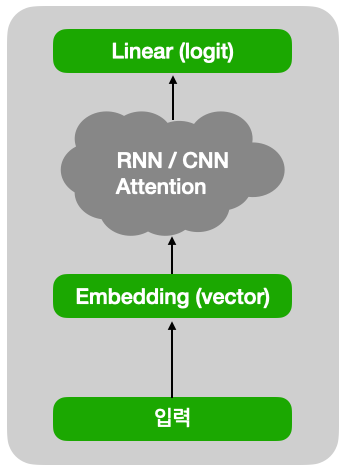

이제 학습용 모델 클래스를 생성합니다.

이때 입력값 voacabulary 개수는 word_to_id 개수입니다.

In [63]:
# 학습용 모델 생성
model = SequencePrediction(len(word_to_id))
model.to(args.device)

print(model)

SequencePrediction(
  (embed): Embedding(9, 4)
  (linear): Linear(in_features=4, out_features=2, bias=True)
)


#8. 학습

이제 데이터를 이용해서 모델 학습을 진행합니다. 우선 학습에 필요한 loss 함수와 optimizer를 생성합니다.

- loss 함수는 정답과 예측값과의 차이를 계산하는 함수입니다. 분류 문제를 푸는 경우 보통 CrossEntropyLoss를 사용합니다. loss가 적다는 의미는 예측값과 정답의 차이가 작다는 의미입니다.
- optimizer는 loss가 줄어드는 방향으로 모델의 파라미터를 변경하는 역할을 담당합니다. 일반적으로 Adam을 많이 사용합니다.

In [69]:
# loss & optimizer 생성
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

다음은 모델의 성능을 평가할 함수를 정의합니다. 모델이 얼마나 정답을 잘 예측하는지 측정하기 위해서입니다.

In [70]:
def accuracy_fn(logits, labels):
    """
    model accuracy 측정
    :param logits: 예측 값
    :param labels: 정답
    """
    # 값이 최대인 index 값
    _, indices = logits.max(-1)
    # label과 비교
    matchs = torch.eq(indices, labels).cpu().numpy()
    total = np.ones_like(matchs)
    acc_val = np.sum(matchs) / max(1, np.sum(total))
    return acc_val

 함수에 대한 내용은 아래와 같습니다.

- line 8: 예측 score 중 값이 최대인 ‘indices’를 생성합니다. 첫 번째 값이 최대이면 0 두 번째 값이 최대이면 1입니다.
- line 10: 예측값과 정답을 비교해서 ‘matchs’를 생성합니다. 두 값이 같으면 True(1)이고 다르면 False(0)입니다.
- line 11: ‘match’와 모양이 동일하고 값이 모두 1인 ‘total’을 생성합니다.
- line 12: match / total 수식으로 예측의 정확도를 ‘acc_val’을 계산합니다. 분모가 0이 되면 오류가 발생하기 때문에 max(1, total)을 이용해서 최솟값이 1이 되도록 합니다.
- line 13: ‘acc_val’를 반환합니다.

다음은 각 epoch 별로 학습을 진행할 함수를 정의합니다. epoch이란 모든 학습데이터를 한번 학습을 완료하는 것을 의미합니다. 자연어처리에서는 학습데이터를 여러 번 학습하기 때문에 이처럼 epoch 별 학습함수를 정의하면 관리가 조금 더 편리합니다.



In [71]:
def train_epoch(args, model, loader, loss_fn, optimizer):
    """
    1 epoch 학습
    :param args: 입력 arguments
    :param model: 모델
    :param loader: 데이터로더
    :param loss_fn: loss 계산함수
    :param optimizer: optimizer
    """
    # model을 train 모드로 전환
    model.train()
    # loss 및 accuracy 저장
    losses, access = [], []
    # data loader에서 batch단위로 처리
    for batch in loader:
        # optimizer 초기화
        optimizer.zero_grad()
        # batch 입력값 처리 (CPU or GPU)
        inputs, labels = map(lambda v: v.to(args.device), batch)
        # 모델 실행
        logits = model(inputs)
        # loss 계산
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        # model weight 변경
        optimizer.step()
        # loss 저장
        loss_val = loss.item()
        losses.append(loss_val)
        # accuracy 계산 및 저장
        acc_val = accuracy_fn(logits, labels)
        access.append(acc_val)

    return np.mean(losses), np.mean(access)

위 함수에 대한 내용은 아래와 같습니다.

- line 11: 모델을 train 모드로 변경합니다.
- line 13: loss를 저장할 변수 ‘losses’와 accuracy를 저장할 변수 ‘access’를 생성합니다.
- line 15: data loader로부터 데이터를 batch단위로 읽어옵니다. batch단위로 읽는 이유는 학습할 데이터는 보통 몇천 개 이상일 경우가 많은데 이것을 한꺼번에 처리가 불가능하기 때문에 나눠서 처리합니다. 이처럼 batch단위로 처리하는 1번의 과정을 step이라고 합니다.
- line 17: ‘optimizer’의 gradient를 모두 0으로 초기화 합니다. 즉 이전에 step에서 계산된 gradient를 0으로 변경 합니다.
- line 19: batch단위 입력을 GPU 또는 CPU에 로딩합니다. CPU를 사용하는 경우라면 이미 로딩되어 있음으로 의미 없는 부분입니다. 그렇지만 이렇게 구현하면 CPU/GPU 둘 다 수정 없이 동작합니다.
- line 21: ‘inputs’을 입력으로 모델의 ‘forward’함수를 실행하고 결과로 ‘logits’을 받습니다.
- line 23~24: loss 함수 ‘loss_fn’을 이용해 loss를 계산하고 loss의 ‘backward’ 함수를 실행해서 미분을 통해 gradient를 구합니다.
- line 26: ‘optimizer’를 이용해서 model의 paramters 값들을 loss가 감소하는 방향으로 변경합니다.
- line 28~29: ‘loss’에서 값을 받아서 ‘losses’에 저장합니다. ‘losses’에는 진행된 모든 step의 loss가 저장되어 있습니다.
- line 31~32: ‘accuracy_fn’ 함수를 이용해서 예측의 정확도를 ‘acc_val’을 계산하고 ‘access’에 저장합니다.
- line 34: ‘losses’의 평균값 및 ‘access’의 평균값을 반환합니다.

다음은 각 epoch 별로 평가를 진행할 함수를 정의합니다.

In [72]:
def eval_epoch(args, model, loader, loss_fn):
    """
    1 epoch 평가
    :param args: 입력 arguments
    :param model: 모델
    :param loader: 데이터로더
    :param loss_fn: loss 계산함수
    """
    # model을 eval 모드로 전환
    model.eval()
    # loss 및 accuracy 저장
    losses, access = [], []
    # 실행시에 gradint 계산 비활성화
    with torch.no_grad():
        for batch in loader:
            # batch 입력값 처리 (CPU or GPU)
            inputs, labels = map(lambda v: v.to(args.device), batch)
            # 모델 실행
            logits = model(inputs)
            # loss 계산
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            # loss 저장
            loss_val = loss.item()
            losses.append(loss_val)
            # accuracy 계산 및 저장
            acc_val = accuracy_fn(logits, labels)
            access.append(acc_val)

    return np.mean(losses), np.mean(access)

위 함수에 대한 내용은 아래와 같습니다.

- line 10: 모델을 eval 모드로 변경합니다.
- line 12: loss를 저장할 변수 ‘losses’와 accuracy를 저장할 변수 ‘access’를 생성합니다.
- line 14: pytorch가 gradient를 계산하지 않도록 선언합니다.
- line 15: data loader로부터 데이터를 batch단위로 읽어옵니다.
- line 17: batch단위 입력을 GPU 또는 CPU에 로딩합니다.
- line 19: ‘inputs’을 입력으로 모델의 ‘forward’함수를 실행하고 결과로 ‘logits’을 받습니다.
- line 21: loss 함수 ‘loss_fn’을 이용해 loss를 계산합니다.
- line 23~24: ‘loss’에서 값을 받아서 ‘losses’에 저장합니다.
- line 26~27: ‘accuracy_fn’ 함수를 이용해서 예측의 정확도를 ‘acc_val’을 계산하고 ‘access’에 저장합니다.
- line 29: ‘losses’의 평균값 및 ‘access’의 평균값을 반환합니다.

다음은 학습과정을 기록할 ‘history’ 변수와 가장좋은 accuracy를 기록할 ‘best_acc’ 변수를 생성합니다.

In [73]:
# 학습 history
history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
# 가장 좋은 acc 값
best_acc = 0

이제 위에서 정의한 학습 관련 함수와 변수들을 이용해서 학습을 진행합니다.

In [74]:
# 학습 및 평가
for e in range(args.n_epoch):
    train_loss, train_acc = train_epoch(args, model, train_loader, loss_fn, optimizer)
    valid_loss, valid_acc = eval_epoch(args, model, valid_loader, loss_fn)
    # 학습 history 저장
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["valid_loss"].append(valid_loss)
    history["valid_acc"].append(valid_acc)
    # 학습과정 출력
    print(f"eopch: {e + 1:3d}, train_loss: {train_loss:.5f}, train_acc: {train_acc: .5f}, valid_loss: {valid_loss:.5f}, valid_acc: {valid_acc:.5f}")
    # best weight 저장
    if best_acc < valid_acc:
        best_acc = valid_acc
        # 저장
        torch.save(
            {"state_dict": model.state_dict(), "valid_acc": valid_acc},
            args.save_path,
        )
        # 저장내용 출력
        print(f"  >> save weights: {args.save_path}")

eopch:   1, train_loss: 0.58629, train_acc:  0.55000, valid_loss: 0.58397, valid_acc: 0.55000
  >> save weights: 01-01-sequence-prediction.pth
eopch:   2, train_loss: 0.58296, train_acc:  0.55000, valid_loss: 0.58075, valid_acc: 0.55000
eopch:   3, train_loss: 0.57972, train_acc:  0.55000, valid_loss: 0.57753, valid_acc: 0.55000
eopch:   4, train_loss: 0.55692, train_acc:  0.58333, valid_loss: 0.57438, valid_acc: 0.55000
eopch:   5, train_loss: 0.58753, train_acc:  0.50000, valid_loss: 0.57147, valid_acc: 0.55000
eopch:   6, train_loss: 0.55246, train_acc:  0.58333, valid_loss: 0.56856, valid_acc: 0.55000
eopch:   7, train_loss: 0.56767, train_acc:  0.55000, valid_loss: 0.56573, valid_acc: 0.55000
eopch:   8, train_loss: 0.54812, train_acc:  0.58333, valid_loss: 0.56287, valid_acc: 0.55000
eopch:   9, train_loss: 0.57673, train_acc:  0.50000, valid_loss: 0.56014, valid_acc: 0.71250
  >> save weights: 01-01-sequence-prediction.pth
eopch:  10, train_loss: 0.54389, train_acc:  0.68333, va

위 코드의 내용은 아래와 같습니다.

- line 2: ‘n_epoch’ 회수만큼 전체 데이터를 반복해서 학습합니다.
- line 3: ‘train_epoch’ 함수를 실행해서 학습을 실행하고 loss와 accuracy를 ‘train_loss’ 와 ‘train_acc’ 변수에 각각 저장합니다.
- line 4: ‘eval_epoch’ 함수를 실행해서 평가를 실행하고 loss와 accuracy를 ‘valid_loss’ 와 ‘valid_acc’ 변수에 각각 저장합니다.
- line 6~9: ‘history’에 ‘train_loss’, ‘train_acc’, ‘valid_loss’, ‘valid_acc’를 저장합니다.
- line 11: 학습과정을 출력합니다.
- line 13: ‘best_acc’와 ‘valid_acc’를 비교합니다. ‘valid_acc’가 클 경우는 이전 모델보다 성능이 좋아졌으므로 모델의 paramter 및 관련 정보를 저장합니다.
- line 14: ‘valid_acc’ 값을 ‘best_acc’에 저장합니다.
- line 16~19: ‘torch.save’ 함수를 이용해서 모델 weights 및 필요한 정보를 저장합니다.
‘model.state_dict()’가 모델 weights 입니다.
기타 추가로 필요하다고 생각되는 내용을 json 형태로 추가해서 저장합니다.
저장 위치는 고정해서 이전에 저장된 값이 있다면 덮어쓰도록 했습니다.
- line 21: 모델이 저장되었음을 출력합니다.

지금까지 학습과정을 그래프로 표현할 함수를 정의합니다.

In [75]:
def draw_history(history):
    """
    학습과정 그래프 출력
    :param history: 학습 이력
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], "b-", label="train_loss")
    plt.plot(history["valid_loss"], "r--", label="valid_loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], "k--", label="train_acc")
    plt.plot(history["valid_acc"], "k--", label="valid_acc")
    plt.xlabel("Epoch")
    plt.legend()

    plt.show()

학습과정을 그래프로 출력합니다.

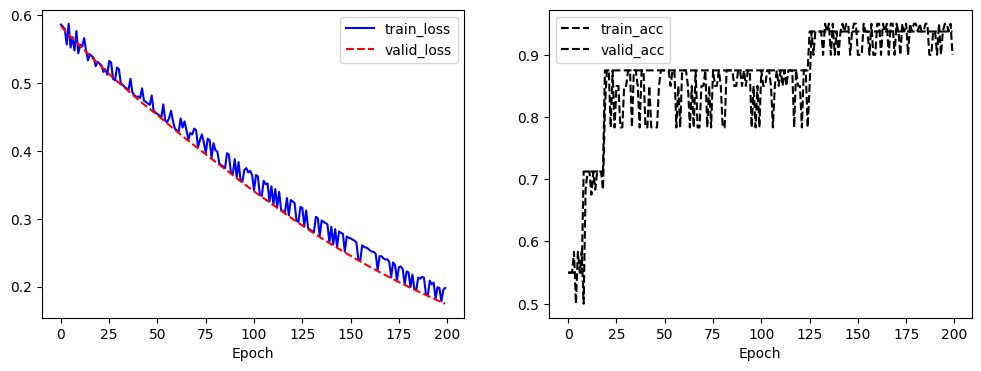

In [76]:
# 학습과정 그래프 출력
draw_history(history)

#9. 테스트

이제 학습된 모델을 테스트해 봅니다. 모델을 테스트하는 이유는 이 모델이 실제 현장에 배포가 가능한지를 확인해보기 위함입니다. 실제 상황에서는 더 다양하고 엄밀하게 테스트를 진행해야 합니다.

우선 테스트용 모델을 생성합니다.

In [77]:
# 테스트용 모델 생성
model = SequencePrediction(len(word_to_id))
model.to(args.device)

print(model)


SequencePrediction(
  (embed): Embedding(9, 4)
  (linear): Linear(in_features=4, out_features=2, bias=True)
)


현재 테스트용 모델은 pytorch에 의해서 랜덤하게 초기화된 모델입니다. 이 모델을 이용해서 성능을 평가해 봅니다. 데이터는 테스트용 데이터를 사용합니다.

In [78]:
# 랜덤 초기화 모델 평가
valid_loss, valid_acc = eval_epoch(args, model, test_loader, loss_fn)

print(valid_loss, valid_acc)

0.9865338504314423 0.45


다음은 학습된 모델의 weights를 이용해서 초기화를 한 후 테스트를 해 봅니다. 우선 저장된 값을 읽어 옵니다.

In [79]:
# 저장된 데이터 로드
save_dict = torch.load(args.save_path)

print(save_dict)

{'state_dict': OrderedDict([('embed.weight', tensor([[-2.6083, -0.2873, -0.0675,  0.1340],
        [ 0.8302,  1.3852,  0.4531, -0.7967],
        [ 2.1200,  0.4627, -0.3215,  0.0681],
        [-0.1308,  0.6206, -1.2875,  0.3755],
        [ 0.7312,  0.7273,  1.3189, -0.8796],
        [ 0.4072, -3.3681, -1.1412, -0.0204],
        [-0.9956,  0.5940, -0.4593,  2.2034],
        [ 1.1043, -1.8788, -0.5945,  0.7126],
        [ 0.6224, -1.3269,  1.2774,  0.9249]])), ('linear.weight', tensor([[ 0.0920, -0.5353, -0.0734, -0.6216],
        [-0.4783, -0.3136, -0.4004, -0.1470]])), ('linear.bias', tensor([ 0.3053, -0.5006]))]), 'valid_acc': 0.9375}


이제 학습된 weights로 모델을 초기화합니다.

In [80]:
# 학습된 weights로 모델 초기화
model.load_state_dict(save_dict['state_dict'])

<All keys matched successfully>

다시한번 모델 성능을 평가해 봅니다.

In [81]:
# 학습된 weights로 초기화 모델 평가
valid_loss, valid_acc = eval_epoch(args, model, test_loader, loss_fn)

print(valid_loss, valid_acc)

0.29018303751945496 0.9375


만일 테스트 결과가 만족스럽지 않다면 이전 과정 (‘데이터’, ‘vocabulary 생성’, ‘학습 및 평가용 데이터 생성’, ‘모델링’, ‘학습’) 중에서 성능 저하의 원인이 되는 부분을 개선하고 학습하고 테스트하는 과정을 반복해야 합니다. 이런 시행착오를 줄이기 위한 효과적인 방법은 많은 논문 또는 블로그를 참고하는 것입니다.

-> TODO

#10. 배포

테스트 결과가 만족스럽다면 이제 학습된 모델을 실제 서비스에 적용합니다. 간단하게 학습됨 모델을 이용해 사용자 입력을 받아서 단어의 명사 여부를 예측해 보겠습니다.

우선 배포용 모델을 생성합니다. 하고 학습된 weights로 모델을 초기화합니다.

In [82]:
# 배포용 모델 생성
model = SequencePrediction(len(word_to_id))
model.to(args.device)

# 저장된 데이터 로드
save_dict = torch.load(args.save_path)

# 학습된 weights로 모델 초기화
model.load_state_dict(save_dict['state_dict'])

<All keys matched successfully>

이제 입력을 받아서 단어별 명사 여부를 예측하는 함수를 정의합니다.

In [83]:
def do_predict(word_to_id, model, string):
    """
    입력에 대한 답변 생성하는 함수
    :param word_to_id: vocabulary
    :param model: model
    :param string: 입력 문자열
    """
    # token 생성
    token = [word_to_id[w] for w in string.strip().split()]

    model.eval()
    with torch.no_grad():
        inputs = torch.tensor([token]).to(args.device)
        logits = model(inputs)
        _, indices = logits.max(-1)
        y_pred = indices[0].numpy()
    result = ["명사" if i == 1 else "기타" for i in y_pred]
    return result

위 함수에 대한 내용은 아래와 같습니다.

- line 9: 입력 문장을 vocabulary를 이용해서 일련번호로 변경합니다.
- line 11: 모델을 eval 모드로 변경합니다.
- line 12: pytorch가 gradient를 계산하지 않도록 선언합니다.
- line 13: 입력 ‘inputs’를 생성합니다. 이때 입력을 1개만 처리하므로 batch 개수는 1입니다.
- line 14: ‘inputs’을 입력으로 모델의 ‘forward’함수를 실행하고 결과로 ‘logits’을 받습니다.
- line 15: ‘logits’ 중 값이 최대인 ‘indices’를 생성합니다.
- line 16: ‘indices’의 값을 numpy 형태로 변경해서 ‘y_pred’ 변수에 저장합니다.
- line 17: 예측값이 1인 경우는 ‘명사’ 0인 경우는 ‘기타’로 바꿔서 ‘result’ 변수에 저장합니다.
- line 18: ‘result’를 반환합니다.

이제 마지막으로 위 함수를 실행해서 예측을 해 봅니다.

In [84]:
# 예측 실행
do_predict(word_to_id, model, "당신은 선생님 입니다")

['기타', '명사', '기타']

위의 do_predict 함수의 입력을 웹페이지나 모바일에서 받아서 실행하도록 간단한 서비스를 구성할 수 있습니다.

-> TODO